# Compare GPs + Plot

In [52]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
import tueplots.figsizes

In [53]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [54]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [55]:
d = 2
def f_currin_high(x):
    # https://www.sfu.ca/~ssurjano/curretal88exp.html
    assert x.ndim==2 and x.size(-1)==d
    x1,x2 = x[:,0],x[:,1]
    y = (1-torch.exp(-1/(2*x2)))*(2300*x1**3+1900*x1**2+2092*x1+60)/(100*x1**3+500*x1**2+4*x1+20)
    return y
def f_currin_low(x):
    assert x.ndim==2 and x.size(-1)==d
    x1,x2 = x[:,0],x[:,1]
    y = 1/4*(
        f_currin_high(torch.hstack([x1[:,None]+0.05,x2[:,None]+0.05])) + 
        f_currin_high(torch.hstack([x1[:,None]+0.05,torch.maximum(x2[:,None]-0.05,torch.zeros(1))])) + 
        f_currin_high(torch.hstack([x1[:,None]-0.05,x2[:,None]+0.05])) + 
        f_currin_high(torch.hstack([x1[:,None]-0.05,torch.maximum(x2[:,None]-0.05,torch.zeros(1))])))
    return y
fs = [f_currin_low, f_currin_high]
num_tasks = len(fs)
ns = [
    torch.tensor([0,2**6],device=device),
    torch.tensor([2**7,2**5],device=device)]

## Parameters

In [56]:
seqs_std = [
    qp.DigitalNetB2(d,seed=11,randomize="DS"),
    qp.DigitalNetB2(d,seed=13,randomize="DS"),
]
seqs_lattice = [
    qp.Lattice(d,seed=7),
    qp.Lattice(d,seed=2),
 ]
seqs_dnb2s = [
    qp.DigitalNetB2(d,seed=7,randomize="DS"),
    qp.DigitalNetB2(d,seed=2,randomize="DS"),
]
ngptypes = 3

In [57]:
_xticks = torch.linspace(0,1,100,device=device)[1:-1]
x0mesh,x1mesh = torch.meshgrid(_xticks,_xticks,indexing="ij")
xticks = torch.hstack([x0mesh.flatten()[:,None],x1mesh.flatten()[:,None]])
yticks = torch.vstack([fs[i](xticks) for i in range(num_tasks)])

## Independent Single Task GPs

In [58]:
pmeans = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_lows = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_highs = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
l2rerrors = torch.ones((ngptypes,num_tasks))
fgp_indep = [ 
    [
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[0]),
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[1]),
    ],
    [
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[0]),
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[1]),
    ],
    [
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvarCombined(d=d,torchify=True,device=device),seqs=seqs_dnb2s[0]),
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvarCombined(d=d,torchify=True,device=device),seqs=seqs_dnb2s[1]),
    ],
]
gpnames = [type(fgp_indep[i][0]).__name__ for i in range(ngptypes)]
for i in range(ngptypes):
    print(gpnames[i])
    for l in range(num_tasks):
        if ns[0][l]>0:
            x_next = fgp_indep[i][l].get_x_next(n=ns[0][l].item())
            y_next = torch.vstack([fs[i](x_next) for i in range(num_tasks)])
            fgp_indep[i][l].add_y_next(y_next[l])
            fgp_indep[i][l].fit()
            pmeans[i][l],_,_,ci_lows[i][l],ci_highs[i][l] = fgp_indep[i][l].post_ci(xticks)
            l2rerrors[i][l] = torch.linalg.norm(pmeans[i][l]-yticks[l])/torch.linalg.norm(yticks[l])

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 6.99e+04   | 6.99e+04  
            5.00e+00 | 5.40e+03   | 5.40e+03  
            1.00e+01 | 2.68e+01   | 2.68e+01  
            1.50e+01 | 9.35e+00   | 9.35e+00  
            2.00e+01 | 2.23e-01   | 2.23e-01  
            2.50e+01 | -2.76e+00  | -2.76e+00 
            3.00e+01 | -3.46e+00  | -3.46e+00 
            3.50e+01 | -3.60e+00  | -3.47e+00 
            4.00e+01 | -3.61e+00  | -3.61e+00 
            4.40e+01 | -3.61e+00  | -3.61e+00 
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 7.11e+02   | 7.11e+02  
            5.00e+00 | 1.65e+02   | 1.65e+02  
            1.00e+01 | 1.35e+02   | 1.36e+02  
            1.50e+01 | 1.35e+02   | 1.35e+02  
            2.00e+01 | 1.35e+02   | 1.35e+02  
            2.50e+01 | 1.35e+02   | 1.35e+02  
            3.00e+01 | 1.34e+02   |

## Multi-Task Fast GPs

In [59]:
fgp_multitask = [
    fastgps.StandardGP(qp.KernelMultiTask(qp.KernelSquaredExponential(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_std),
    fastgps.FastGPLattice(qp.KernelMultiTask(qp.KernelShiftInvar(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_lattice),
    fastgps.FastGPDigitalNetB2(qp.KernelMultiTask(qp.KernelDigShiftInvarCombined(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_dnb2s),
]
pmeans_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_lows_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_highs_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
l2rerrors_mt = torch.ones((ngptypes,num_tasks))
for i in range(ngptypes):
    print(gpnames[i])
    x_next = fgp_multitask[i].get_x_next(n=ns[1])
    y_next = [fs[i](x_next[i]) for i in range(num_tasks)]
    fgp_multitask[i].add_y_next(y_next)
    fgp_multitask[i].fit()
    pmeans_mt[i],_,_,ci_lows_mt[i],ci_highs_mt[i] = fgp_multitask[i].post_ci(xticks)
    l2rerrors_mt[i] = torch.linalg.norm(pmeans_mt[i]-yticks,dim=-1)/torch.linalg.norm(yticks,dim=-1)

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.38e+05   | 1.38e+05  
            5.00e+00 | 3.04e+03   | 3.04e+03  
            1.00e+01 | -1.58e+02  | -1.58e+02 
            1.50e+01 | -1.75e+02  | -1.75e+02 
            2.00e+01 | -1.97e+02  | -1.97e+02 
            2.50e+01 | -2.00e+02  | -2.00e+02 
            3.00e+01 | -2.00e+02  | -2.00e+02 
            3.50e+01 | -2.01e+02  | -2.01e+02 
            4.00e+01 | -2.01e+02  | -2.01e+02 
            4.40e+01 | -2.01e+02  | -2.01e+02 
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.46e+03   | 2.46e+03  
            5.00e+00 | 3.63e+02   | 3.63e+02  
            1.00e+01 | 3.39e+02   | 3.39e+02  
            1.50e+01 | 3.28e+02   | 3.28e+02  
            2.00e+01 | 3.14e+02   | 3.14e+02  
            2.50e+01 | 3.13e+02   | 3.15e+02  
            3.00e+01 | 3.11e+02   |

## Compare Accuracy

In [60]:
pd.DataFrame({gpnames[i]+" task %d"%j: [l2rerrors[i,j].item(),l2rerrors_mt[i,j].item()] for j in range(num_tasks) for i in range(ngptypes)})

,StandardGP task 0,FastGPLattice task 0,FastGPDigitalNetB2 task 0,StandardGP task 1,FastGPLattice task 1,FastGPDigitalNetB2 task 1
0,1.000000,1.000000,1.000000,0.003604,0.089231,0.072418
1,0.001897,0.082094,0.033718,0.005856,0.089346,0.041112


## Plot

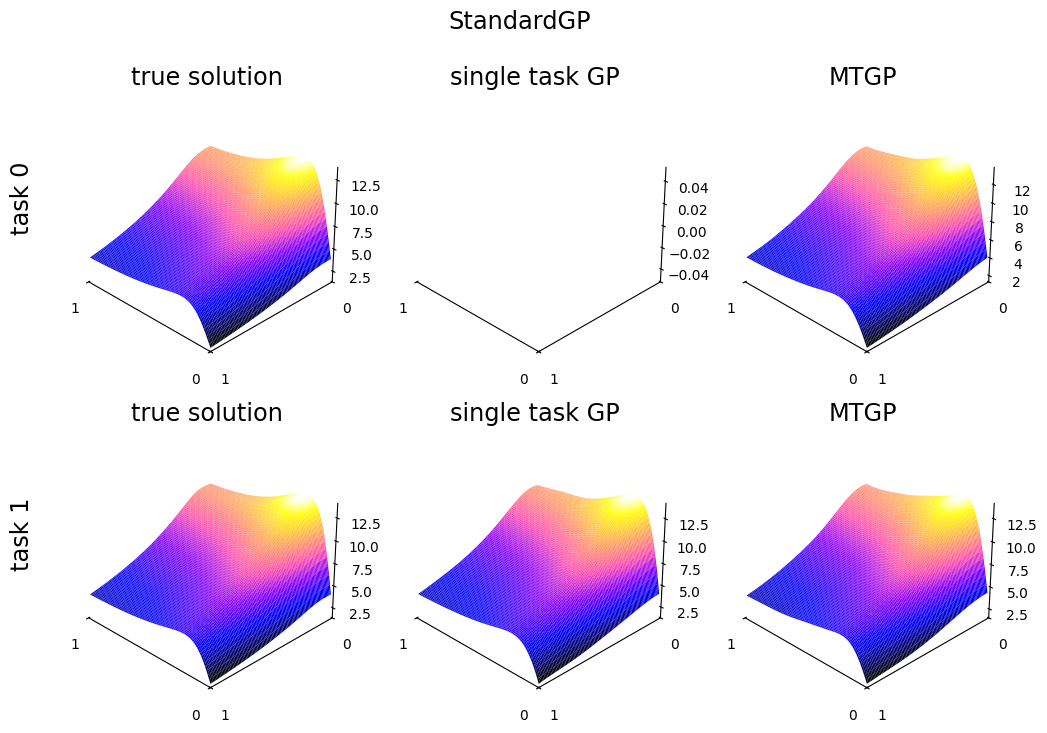

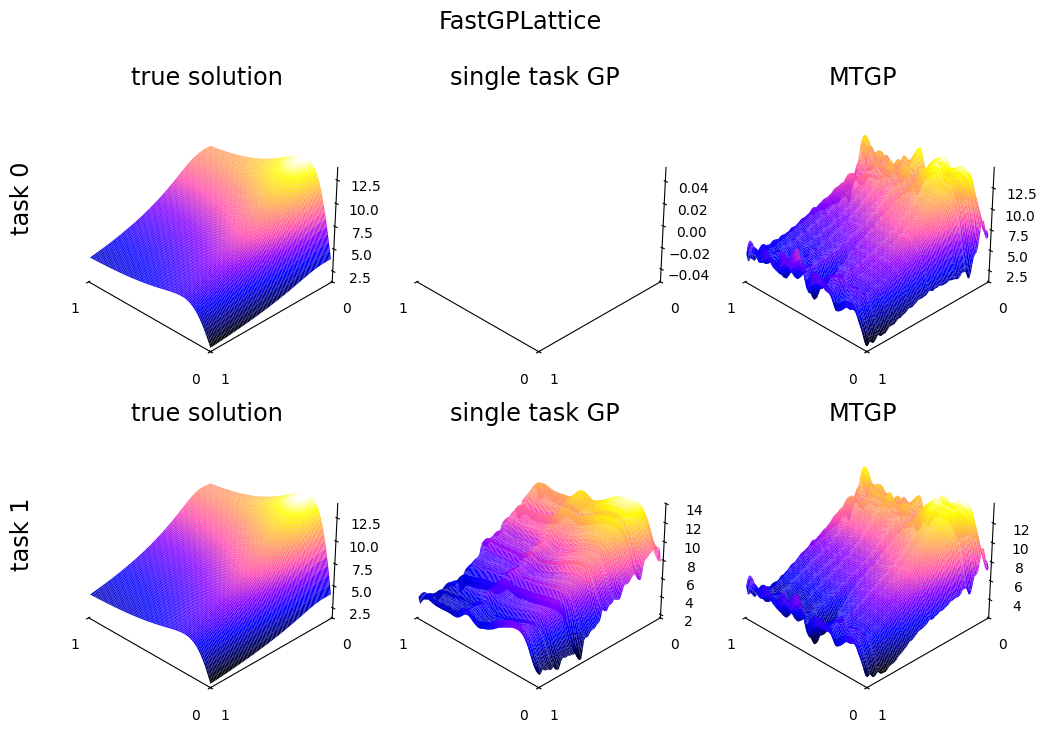

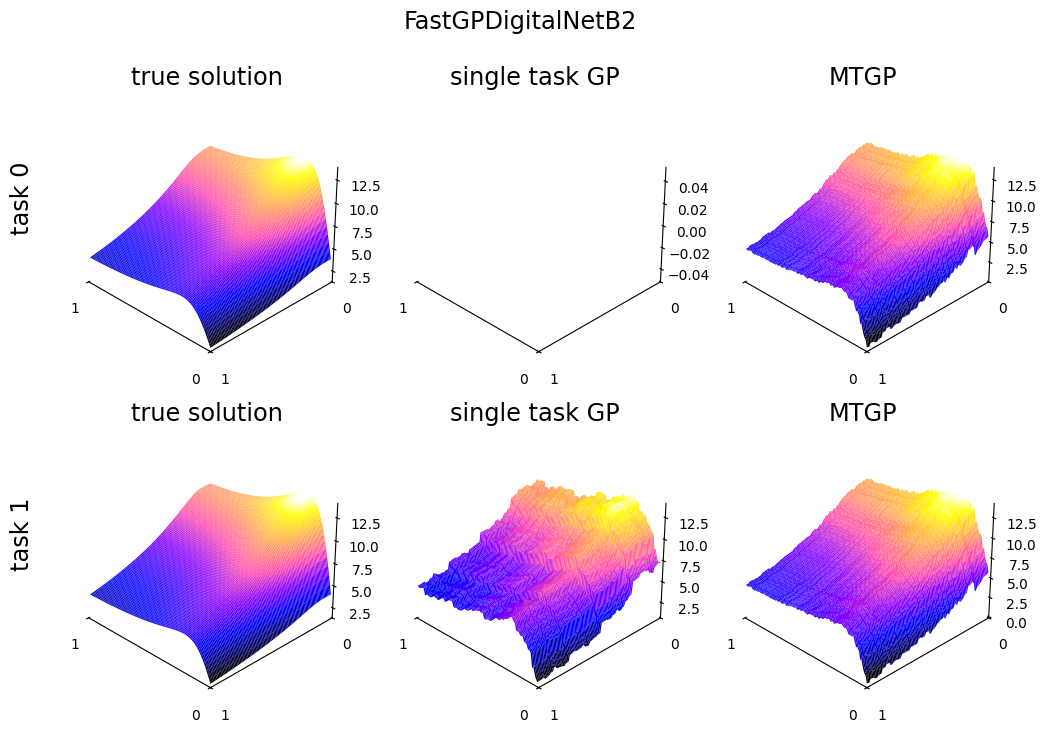

In [61]:
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True) # https://seaborn.pydata.org/tutorial/color_palettes.html
nrows = num_tasks
ncols = 3 
for l in range(ngptypes):
    fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': '3d'},figsize=(4*ncols,4*nrows))
    for i in range(num_tasks):
        for j,(yplt,name) in enumerate(zip([yticks[i],pmeans[l][i],pmeans_mt[l][i]],["true solution","single task GP","MTGP"])):
            ax[i,j].plot_surface(x0mesh,x1mesh,yplt.reshape(x0mesh.shape),rstride=1,cstride=1,antialiased=True,cmap="gnuplot2")
            ax[i,j].set_title(name,fontsize="xx-large")
            ax[i,j].set_xlim([0,1])
            ax[i,j].set_xticks([0,1])
            ax[i,j].set_ylim([0,1])
            ax[i,j].set_yticks([0,1])
            ax[i,j].grid(False)
            ax[i,j].xaxis.pane.set_alpha(0.0)
            ax[i,j].yaxis.pane.set_alpha(0.0)
            ax[i,j].zaxis.pane.set_alpha(0.0)
            ax[i,j].view_init(azim=135)
        # ax[i,0].set_title("task %d"%i,rotation="vertical",x=0,y=0.5,fontsize="xx-large")
        fig.text(ax[0,0].get_position().x0-.05,(ax[i,0].get_position().y0+ax[i,0].get_position().y1)/2,"task %d"%i,rotation="vertical",fontsize="xx-large")
    fig.suptitle(gpnames[l],fontsize="xx-large")
    fig.savefig("./mtgps.2d.%s.pdf"%gpnames[l],bbox_inches="tight")